Тимофеев Алексей Владимирович, М8О-407Б-19

## Heart Attack Analysis & Prediction Dataset
## Набор данных для прогнозирования сердечной недостаточности
https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import math
import collections

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_curve, recall_score, precision_score
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.base import BaseEstimator, ClassifierMixin



In [2]:
data = pd.read_csv('heart.csv')
print(data.shape)
data.head()

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Об этом наборе данных

* Age : Возраст пациента

* Sex: Пол пациента

* exang: стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)

* cp: тип боли в груди тип боли в груди

    * Value 1: типичная стенокардия
    * Value 2: атипичная стенокардия
    * Value 3: неангинальная боль
    * Value 4: бессимптомное течение
* trtbps: артериальное давление в состоянии покоя (в мм рт. ст.)

* chol: холесторал в мг / дл, определяемый с помощью датчика ИМТ

* fbs: (уровень сахара в крови натощак> 120 мг / дл) (1 = истина; 0 = ложь)

* rest_ecg : результаты электрокардиографии в состоянии покоя

    * Value 0: нормальное
    * Value 1: аномалия зубца ST-T (инверсия зубца T и / или повышение или понижение ST> 0,05 мВ)
    * Value 2: отображение вероятной или определенной гипертрофии левого желудочка по критериям Эстеса
    
* thalach: достигнута максимальная частота сердечных сокращений

* target : 0 = меньше шансов сердечного приступа 1 = больше шансов сердечного приступа

Удалим дубликаты, если они есть

In [3]:
data.drop_duplicates(keep='last')

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
data.corr()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


<AxesSubplot:>

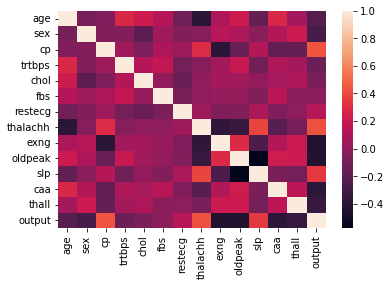

In [5]:
sns.heatmap(data.corr())

Больше всего влияют: ST_Slope, ExerciseAngina, ChestPainType  
Меньше всего: RestingECG

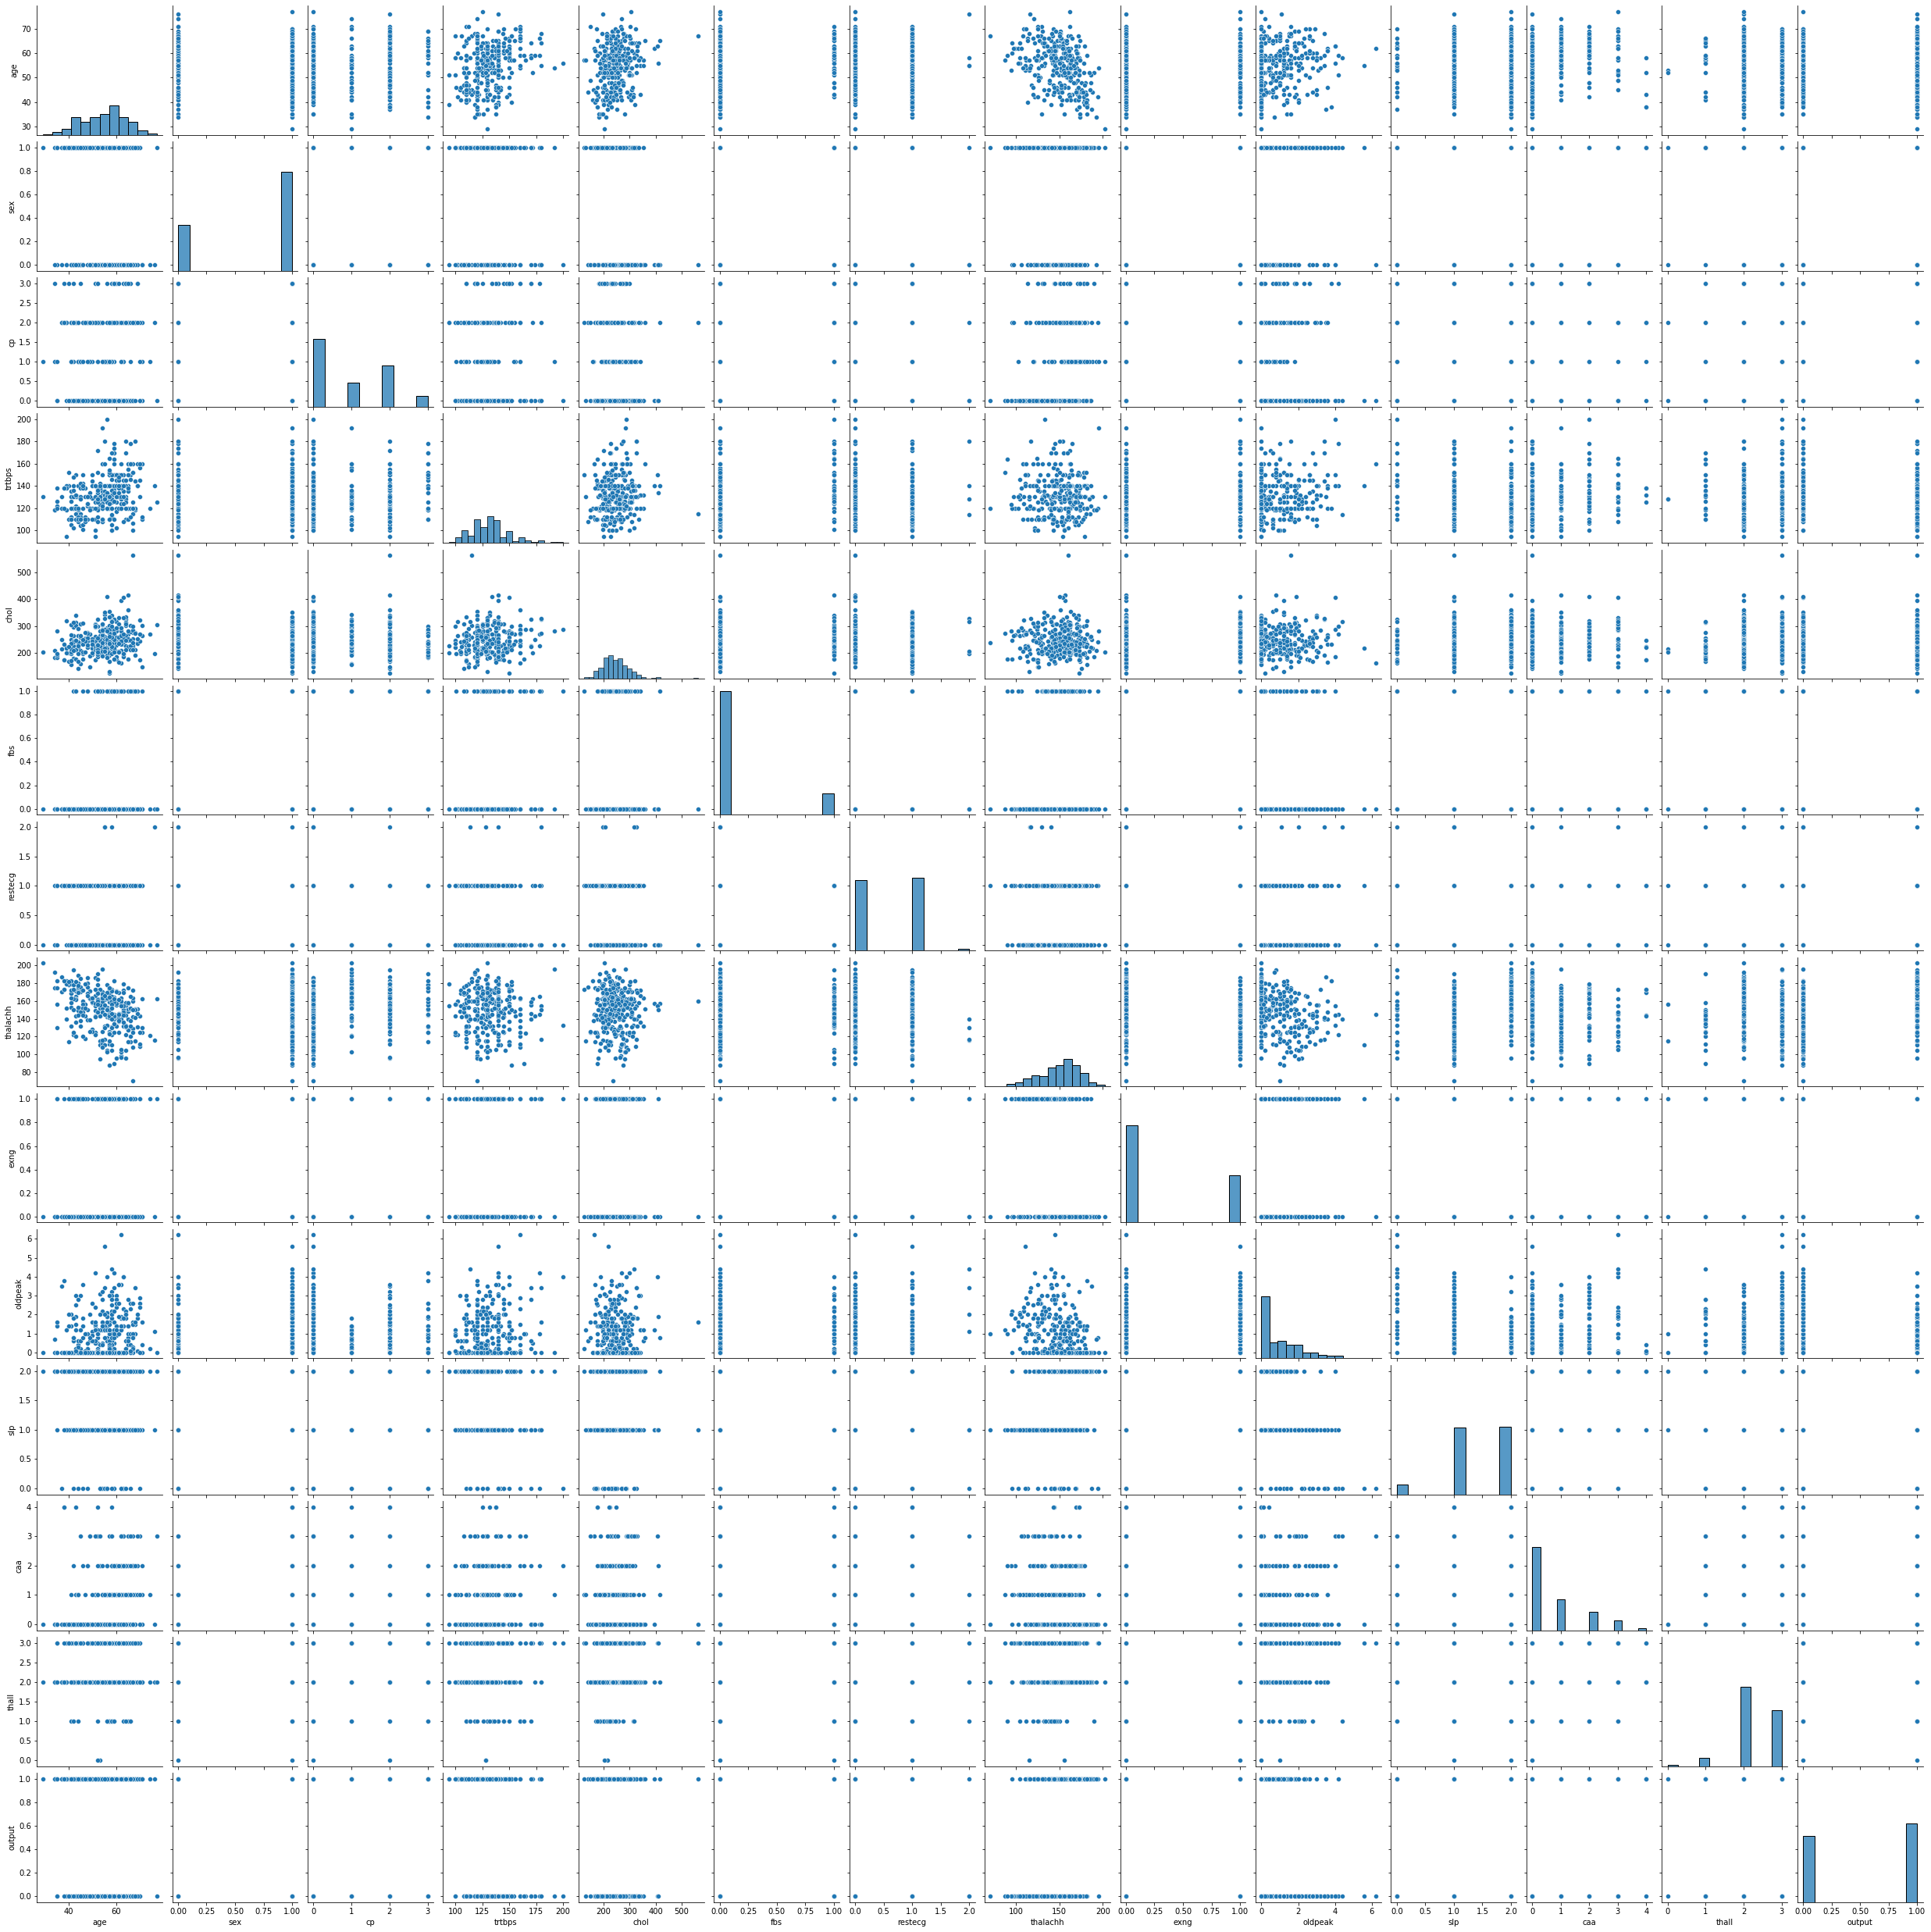

In [6]:
sns.pairplot(data=data)
None

# k-Nearest Neighbors (KNN)

In [7]:
from sklearn.model_selection import train_test_split
x = data.drop(columns='output')
y = data['output']
x_train, x_test, train_labels, test_labels = train_test_split(x.to_numpy(), y.to_numpy(), test_size = 0.2, random_state = 10)

In [8]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        
    def euclidean_distance(self, data, row):
        distance = 0
        for i in range(len(data)): 
            distance += (data[i] - row[i]) ** 2
        return math.sqrt(distance)
        
    def predict(self, dataX):
        res = np.ndarray((dataX.shape[0],))
        for j, data in enumerate(dataX):
            distances = []
            for i, row in enumerate(self.data):
                distances.append((self.euclidean_distance(data, row), self.labels[i]))
            distances.sort(key = lambda tup: tup[0])
            dictionary = collections.defaultdict(int)
            for i in range(self.k):
                dictionary[distances[i][1]] += 1
            res[j] = max(dictionary.items(), key = lambda tup: tup[1])[0]
        return res


In [9]:

knn = Pipeline(steps = [('knn', KNN(5))])
print(knn.get_params())


{'memory': None, 'steps': [('knn', KNN(k=5))], 'verbose': False, 'knn': KNN(k=5), 'knn__k': 5}


In [10]:
def scores(model, X, y_true):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    figure = plt.figure(figsize = (20, 5))
    matr = confusion_matrix(y_true, y_pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matr).plot(ax = ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true = y_true, y_pred = y_pred, name = "ROC-кривая", ax = ax)
    plt.show()

{'knn__k': 3}
Accuracy train: 0.6697278911564626
Accuracy: 0.5737704918032787
Recall: 0.7307692307692307
Precision: 0.5


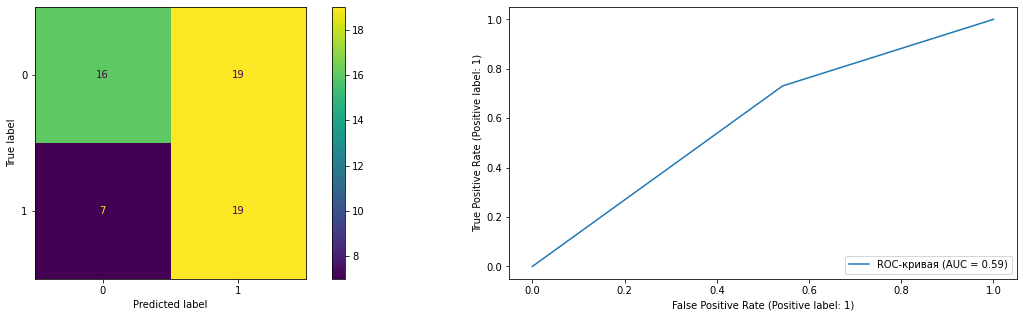

In [11]:
test = []

for i in range(1, 25):
    test.append(i)

gcv = GridSearchCV(estimator = knn, param_grid={'knn__k': test})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")

kNN_best = gcv.best_estimator_
scores(kNN_best, x_test, test_labels)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline(steps = [('knn', KNeighborsClassifier(4))])
print(knn.get_params())

{'memory': None, 'steps': [('knn', KNeighborsClassifier(n_neighbors=4))], 'verbose': False, 'knn': KNeighborsClassifier(n_neighbors=4), 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': None, 'knn__n_neighbors': 4, 'knn__p': 2, 'knn__weights': 'uniform'}


{'knn__n_neighbors': 3}
Accuracy train: 0.6697278911564626
Accuracy: 0.5737704918032787
Recall: 0.7307692307692307
Precision: 0.5


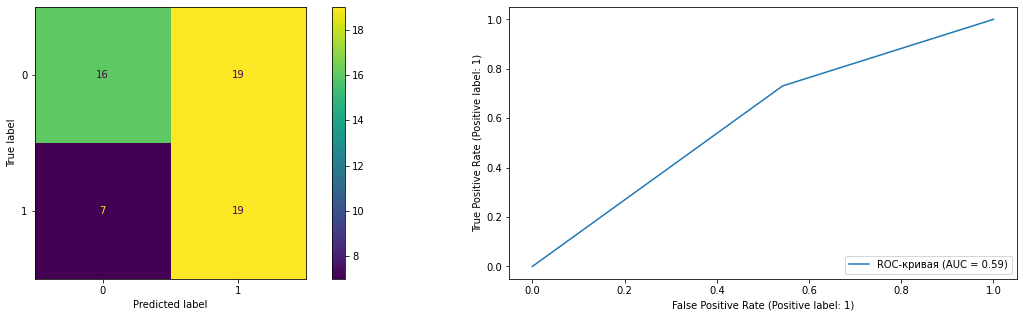

In [13]:
gcv = GridSearchCV(estimator = knn, param_grid={'knn__n_neighbors': test})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")

kNN_best = gcv.best_estimator_
scores(kNN_best, x_test, test_labels)

# Naive Bayes

In [14]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, bins):
        self.bins = bins
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.classes = []
        for j in np.unique(labels):
            
            self.classes.append([])
            for i in range (data.shape[1]):
                self.classes[j].append([*np.histogram(data[labels == j, i], bins = self.bins)])
                self.classes[j][-1][0] = self.classes[j][-1][0].astype('float64') / len(data[labels == j, i])
        
        self.prclasses = np.unique(labels, return_counts = True)[1] / len(labels)
        
    def predict(self, maindata):
        res = np.ndarray((maindata.shape[0],))
        for j, data in enumerate(maindata):
            maximum = 0
            ans = 0
            for i in range(len(self.classes)):
                p = self.prclasses[i]
                for k in range(len(self.classes[i])):
                    ind = np.digitize(data[k], self.classes[i][k][1])
                    
                    if ind >= len(self.classes[i][k][1]) or ind <= 0:
                        p = 0
                    else:
                        p *= self.classes[i][k][0][ind - 1]
                    
                if p > maximum:
                    maximum = p
                    ans = i
            res[j] = ans
        return res  

In [15]:
bn = Pipeline(steps = [('normalizer', Normalizer()), ('bn', NaiveBayes(10))])
bn.get_params()

{'memory': None,
 'steps': [('normalizer', Normalizer()), ('bn', NaiveBayes(bins=10))],
 'verbose': False,
 'normalizer': Normalizer(),
 'bn': NaiveBayes(bins=10),
 'normalizer__copy': True,
 'normalizer__norm': 'l2',
 'bn__bins': 10}

{'bn__bins': 8}
Accuracy train: 0.7812925170068027
Accuracy: 0.7868852459016393
Recall: 0.8461538461538461
Precision: 0.7096774193548387


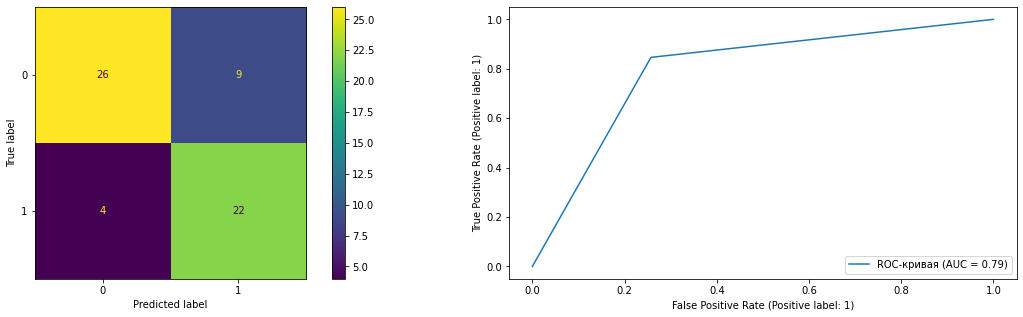

In [16]:
test = []
for i in range(2, 100):
    test.append(i)

gcv = GridSearchCV(estimator = bn, param_grid={'bn__bins': test})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")

NB_best = gcv.best_estimator_
scores(NB_best, x_test, test_labels)

Accuracy: 0.7868852459016393
Recall: 0.7692307692307693
Precision: 0.7407407407407407


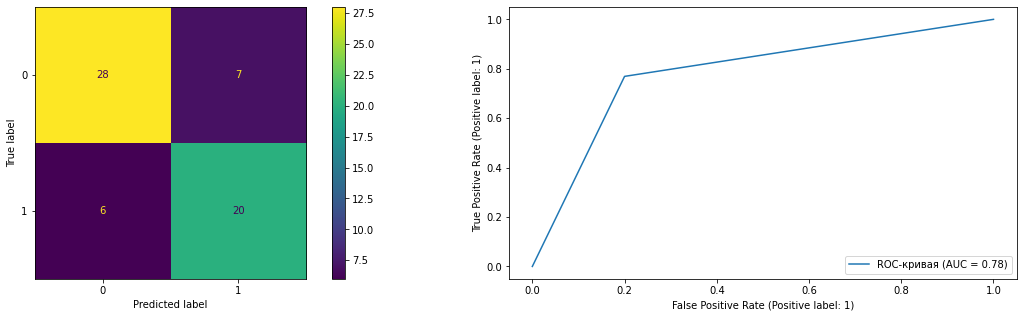

In [17]:
from sklearn.naive_bayes import GaussianNB

bn = Pipeline(steps = [('normalizer', Normalizer()),('bn', GaussianNB())])
bn.fit(x_train, train_labels)

scores(bn, x_test, test_labels)

# Logistic Regression

In [18]:
class Logistic(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, nepoch, batch_size):
        self.lr = lr
        self.nepoch = nepoch
        self.batch_size = batch_size
        
    def fit(self, data, labels):
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis = 1)
        self.W = np.random.normal(0, 1, (len(data[0]),))
        
        for i in range(self.nepoch):
            for i in range(0, len(data), self.batch_size):
                xb = data[i:i + self.batch_size]
                yb = labels[i:i + self.batch_size]
                p = np.dot(self.W, xb.T)
                s = self.sigmoid(p)
                dp = np.dot(xb.T, (s - yb).T)
                self.W -= self.lr * dp
        
    def predict(self, maindata):
        maindata = np.concatenate((maindata, np.ones((maindata.shape[0],1))), axis = 1)
        p = np.dot(self.W, maindata.T)
        s = self.sigmoid(p)
        return (s > 0.5).astype('int64')

    def sigmoid(self, x):
        self.l = 1 / (1 + np.exp(-x))
        return self.l


In [19]:
import sklearn
from sklearn.preprocessing import Normalizer

log = Pipeline(steps = [('normalizer', Normalizer()),('log', Logistic(0.1, 10, 5))])
print(log.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('log', Logistic(batch_size=5, lr=0.1, nepoch=10))], 'verbose': False, 'normalizer': Normalizer(), 'log': Logistic(batch_size=5, lr=0.1, nepoch=10), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'log__batch_size': 5, 'log__lr': 0.1, 'log__nepoch': 10}


{'log__batch_size': 1, 'log__lr': 0.1, 'log__nepoch': 20}
Accuracy train: 0.6447278911564627
Accuracy: 0.5737704918032787
Recall: 0.9615384615384616
Precision: 0.5


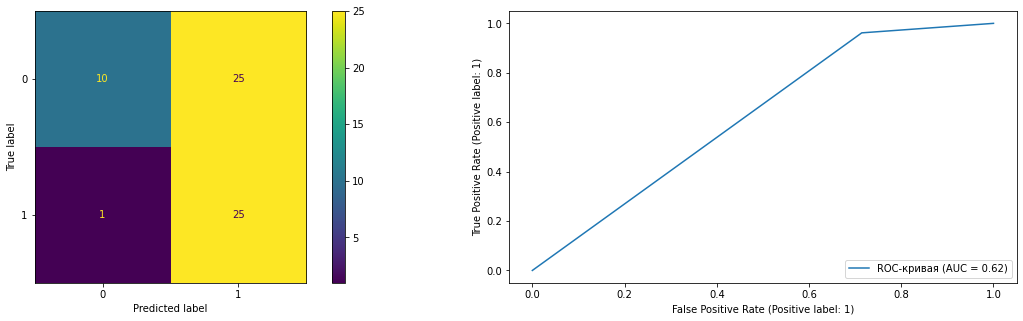

In [20]:
gcv = GridSearchCV(estimator = log, param_grid={'log__nepoch': [1, 5, 10, 20], 'log__batch_size': [1, 5, 10], 'log__lr': [0.1, 0.01, 0.001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
 
Log_best = gcv.best_estimator_
scores(Log_best, x_test, test_labels)

In [21]:
from sklearn.linear_model import SGDClassifier

log = Pipeline(steps = [('normalizer', Normalizer()),('log', SGDClassifier(loss = 'log'))])
print(log.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('log', SGDClassifier(loss='log'))], 'verbose': False, 'normalizer': Normalizer(), 'log': SGDClassifier(loss='log'), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'log__alpha': 0.0001, 'log__average': False, 'log__class_weight': None, 'log__early_stopping': False, 'log__epsilon': 0.1, 'log__eta0': 0.0, 'log__fit_intercept': True, 'log__l1_ratio': 0.15, 'log__learning_rate': 'optimal', 'log__loss': 'log', 'log__max_iter': 1000, 'log__n_iter_no_change': 5, 'log__n_jobs': None, 'log__penalty': 'l2', 'log__power_t': 0.5, 'log__random_state': None, 'log__shuffle': True, 'log__tol': 0.001, 'log__validation_fraction': 0.1, 'log__verbose': 0, 'log__warm_start': False}


{'log__alpha': 0.001, 'log__max_iter': 100}
Accuracy train: 0.6656462585034013
Accuracy: 0.5737704918032787
Recall: 0.8846153846153846
Precision: 0.5


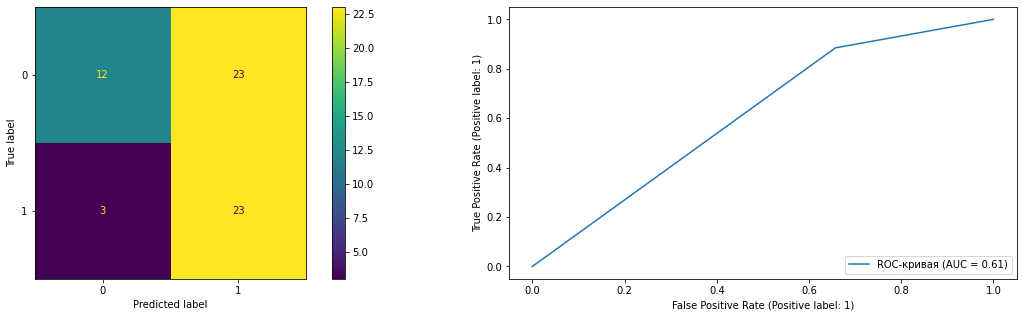

In [22]:
gcv = GridSearchCV(estimator = log, param_grid={'log__max_iter': [100, 1000, 1500], 'log__alpha': [0.1, 0.001, 0.0001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
 
Log_best = gcv.best_estimator_
scores(Log_best, x_test, test_labels)

# SVM

In [23]:
test_labels[test_labels == 0] = -1
train_labels[train_labels == 0] = -1

In [24]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, lambd,  batch_size, nepoch):
        self.nepoch = nepoch
        self.lr = lr
        self.lambd = lambd
        self.batch_size = batch_size
        
    def fit(self, data, labels):
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        self.W = np.random.normal(0, 1, (len(data[0]),))
        
        for i in range(self.nepoch):
            for i in range(0, len(data), self.batch_size):
                xb = data[i:i + self.batch_size]
                yb = labels[i:i + self.batch_size]
                
                p = np.dot(self.W, xb.T)

                sums = np.zeros_like(self.W)
                for i in range(len(p)):
                    if 1 - p[i] * yb[i] > 0:
                        sums -= xb[i] * yb[i]

                dp = 2 * self.lambd * self.W + sums
                self.W -= self.lr * dp
                
                
    def predict(self, maindata):
        maindata = np.concatenate((maindata, np.ones((maindata.shape[0],1))), axis=1)
        p = np.dot(self.W, maindata.T)
        return np.sign(p)

In [25]:
lin = Pipeline(steps = [('normalizer', Normalizer()),('lin', SVM(0.03, 0.00001, 10, 10))])
print(lin.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('lin', SVM(batch_size=10, lambd=1e-05, lr=0.03, nepoch=10))], 'verbose': False, 'normalizer': Normalizer(), 'lin': SVM(batch_size=10, lambd=1e-05, lr=0.03, nepoch=10), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'lin__batch_size': 10, 'lin__lambd': 1e-05, 'lin__lr': 0.03, 'lin__nepoch': 10}


{'lin__batch_size': 1, 'lin__lambd': 0, 'lin__lr': 0.5, 'lin__nepoch': 20}
Accuracy train: 0.6571428571428571
Accuracy: 0.639344262295082
Recall: 0.34615384615384615
Precision: 0.6428571428571429


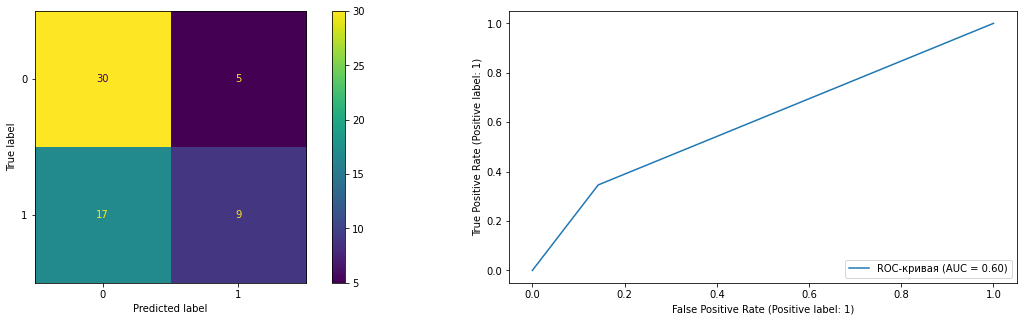

In [26]:
gcv = GridSearchCV(estimator = lin, param_grid={'lin__lambd': [0, 0.00001, 0.001, 0.1], 'lin__nepoch': [1, 5, 10, 20], 'lin__batch_size': [1, 5, 10], 'lin__lr': [0.5, 0.1, 0.01, 0.001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
 
lin_best = gcv.best_estimator_
scores(lin_best, x_test, test_labels)

In [27]:
with open('best_svm.pickle', 'wb') as f:
    pickle.dump(gcv.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

In [28]:
lin = Pipeline(steps = [('normalizer', Normalizer()),('lin', SGDClassifier(loss = 'hinge'))])
print(lin.get_params())

{'memory': None, 'steps': [('normalizer', Normalizer()), ('lin', SGDClassifier())], 'verbose': False, 'normalizer': Normalizer(), 'lin': SGDClassifier(), 'normalizer__copy': True, 'normalizer__norm': 'l2', 'lin__alpha': 0.0001, 'lin__average': False, 'lin__class_weight': None, 'lin__early_stopping': False, 'lin__epsilon': 0.1, 'lin__eta0': 0.0, 'lin__fit_intercept': True, 'lin__l1_ratio': 0.15, 'lin__learning_rate': 'optimal', 'lin__loss': 'hinge', 'lin__max_iter': 1000, 'lin__n_iter_no_change': 5, 'lin__n_jobs': None, 'lin__penalty': 'l2', 'lin__power_t': 0.5, 'lin__random_state': None, 'lin__shuffle': True, 'lin__tol': 0.001, 'lin__validation_fraction': 0.1, 'lin__verbose': 0, 'lin__warm_start': False}


{'lin__alpha': 0.001, 'lin__max_iter': 1000}
Accuracy train: 0.6572278911564626
Accuracy: 0.6557377049180327
Recall: 0.2692307692307692
Precision: 0.7777777777777778


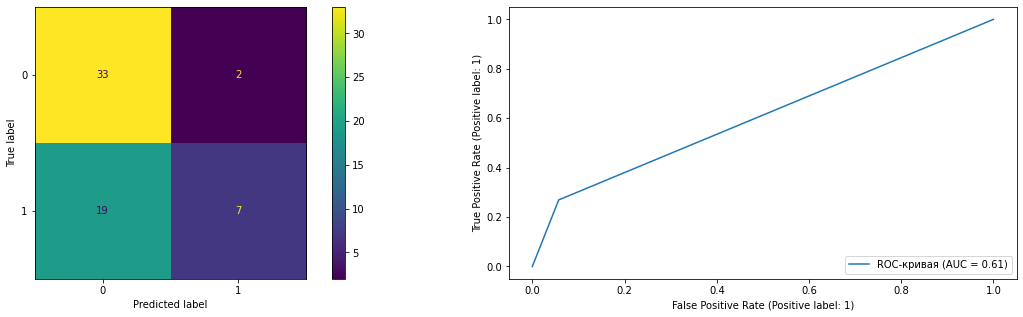

In [29]:
gcv = GridSearchCV(estimator = lin, param_grid={'lin__max_iter': [100, 1000, 1500], 'lin__alpha': [0.1, 0.001, 0.0001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")

lin_best = gcv.best_estimator_
scores(lin_best, x_test, test_labels)

Попробуем увеличить точность, сделав бинаризацию категориальных параметров.

In [30]:
data = pd.get_dummies(data, columns=["cp", "thall", "caa", "slp"])
data['new'] = data['thalachh'] * data['oldpeak'] 
data.head()

,age,sex,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,output,...,thall_3,caa_0,caa_1,caa_2,caa_3,caa_4,slp_0,slp_1,slp_2,new
0,63,1,145,233,1,0,150,0,2.3,1,...,0,1,0,0,0,0,1,0,0,345.0
1,37,1,130,250,0,1,187,0,3.5,1,...,0,1,0,0,0,0,1,0,0,654.5
2,41,0,130,204,0,0,172,0,1.4,1,...,0,1,0,0,0,0,0,0,1,240.8
3,56,1,120,236,0,1,178,0,0.8,1,...,0,1,0,0,0,0,0,0,1,142.4
4,57,0,120,354,0,1,163,1,0.6,1,...,0,1,0,0,0,0,0,0,1,97.8


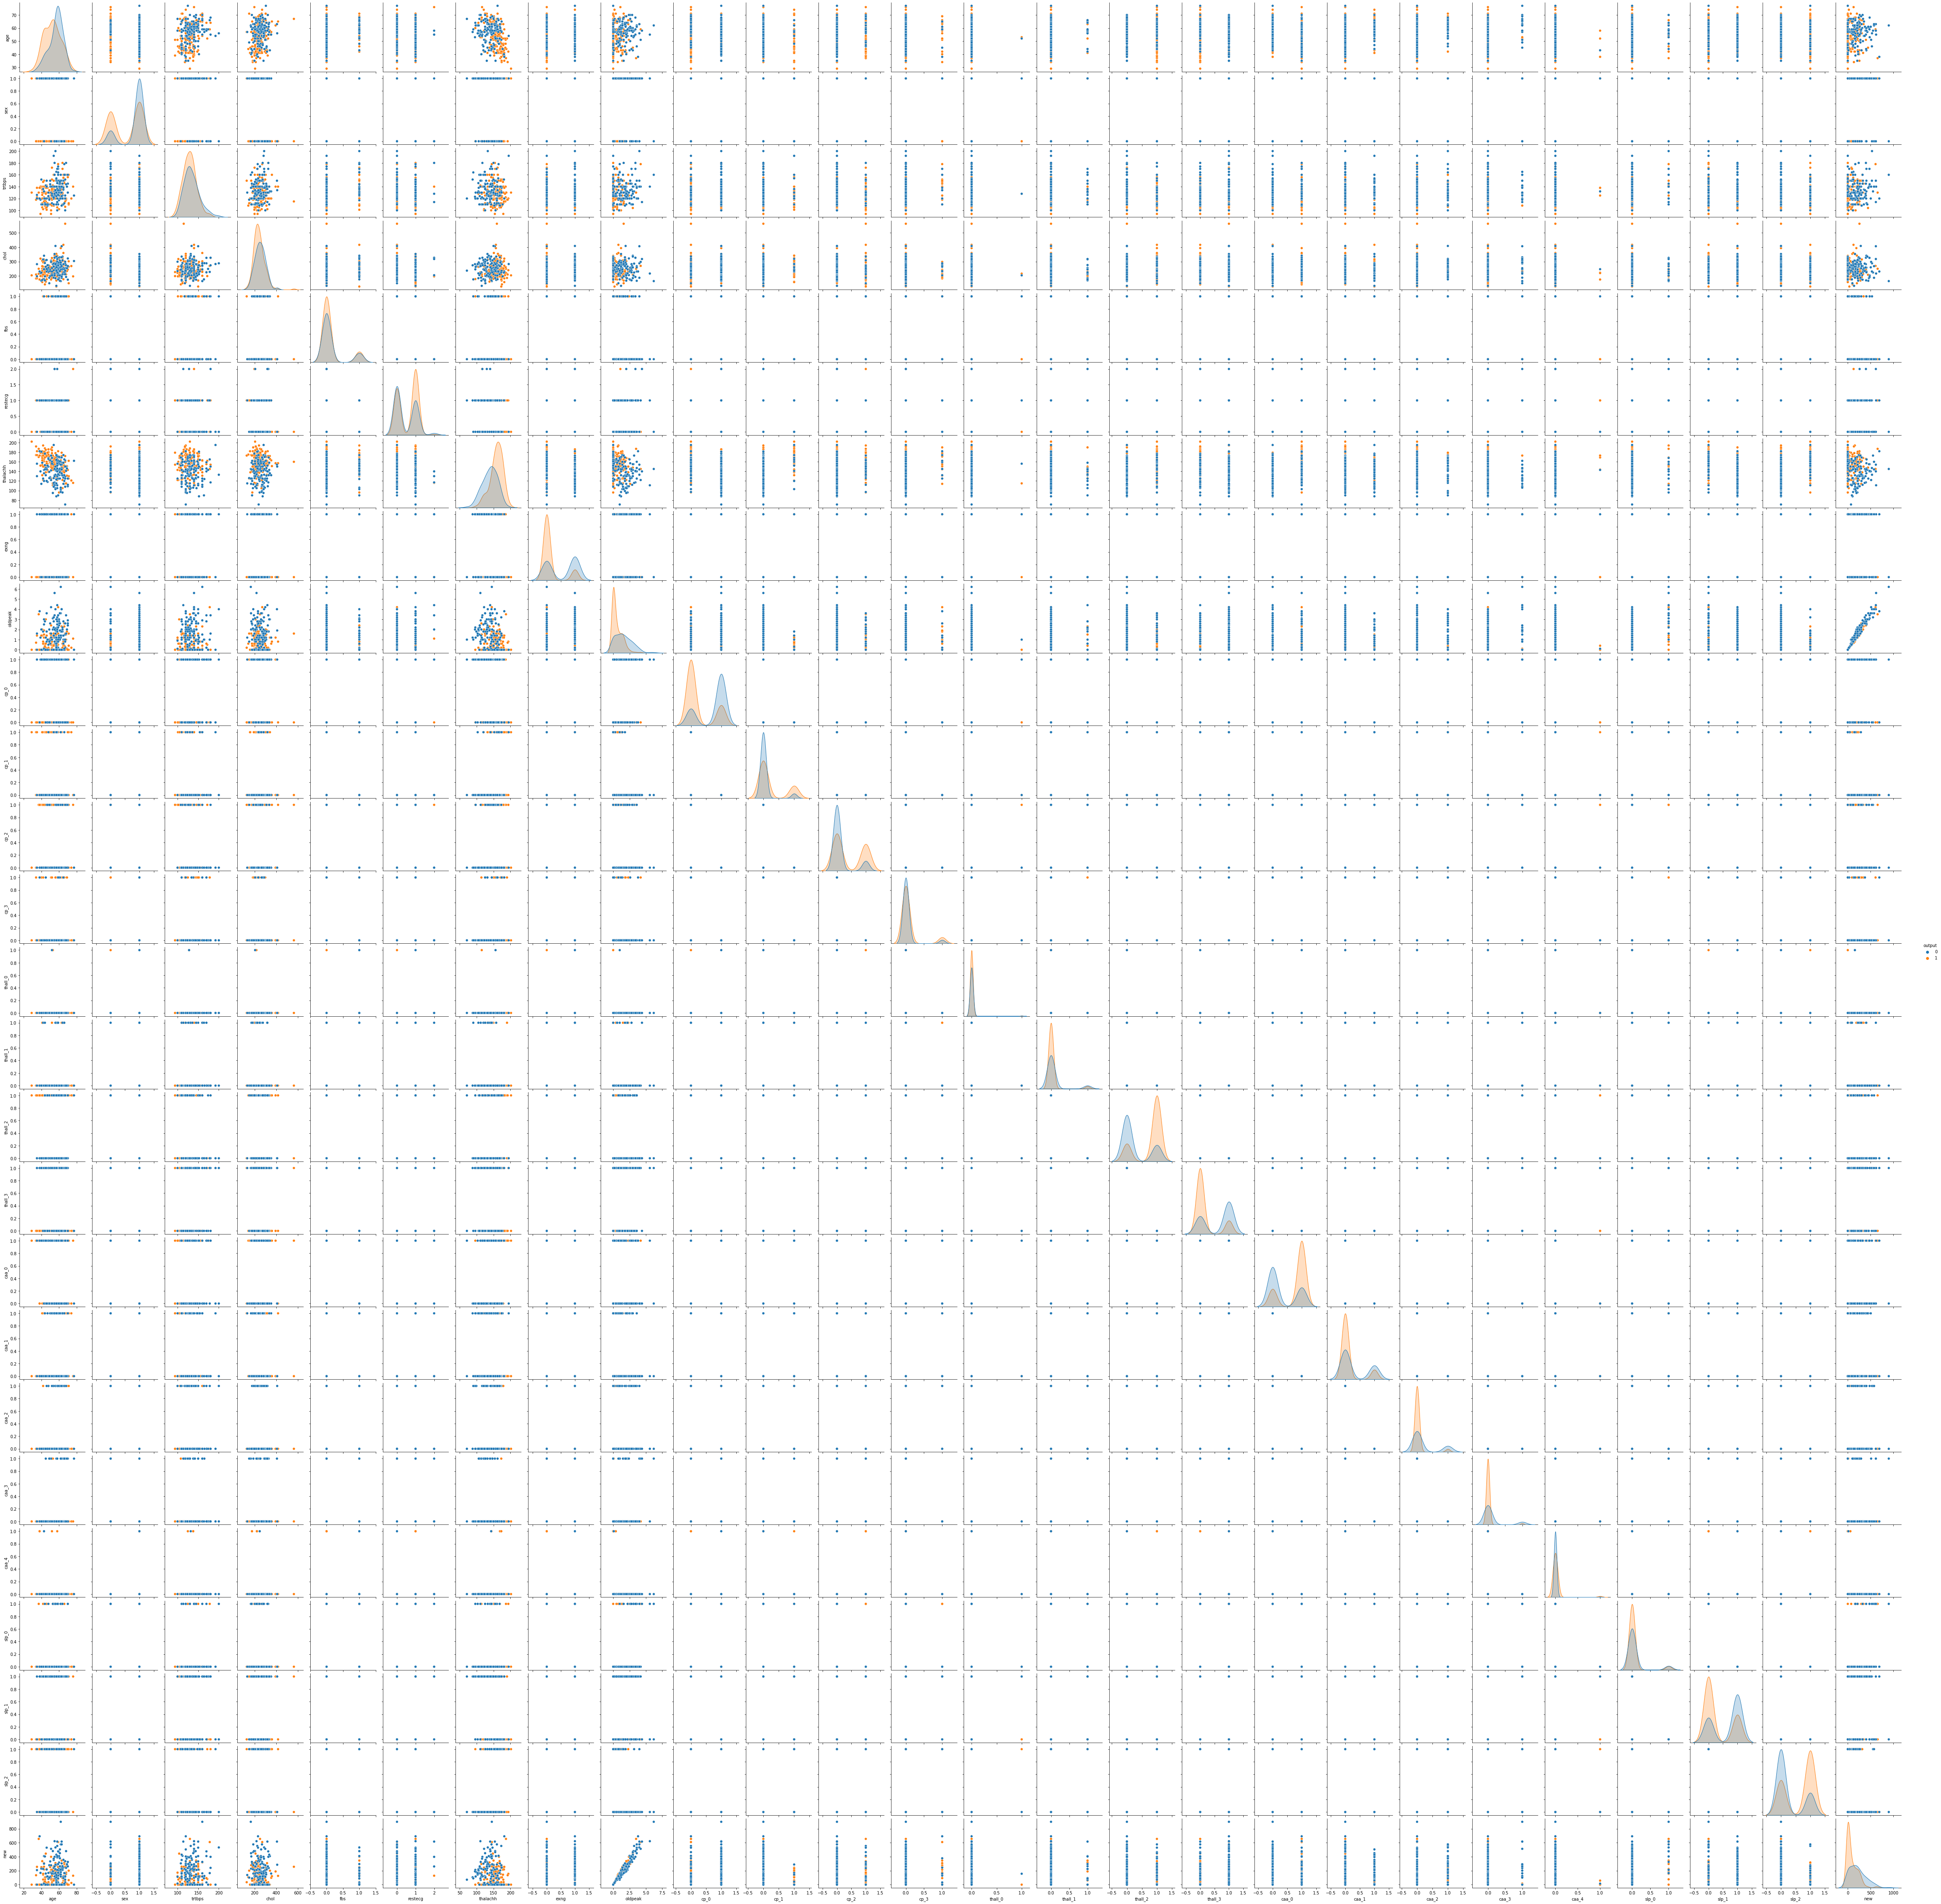

In [31]:
sns.pairplot(data = data, hue = 'output')
None

In [32]:
from sklearn.model_selection import train_test_split
x = data.drop(columns='output')
y = data['output']
x_train, x_test, train_labels, test_labels = train_test_split(x.to_numpy(), y.to_numpy(), test_size = 0.2, random_state = 10)

{'log__batch_size': 5, 'log__lr': 0.1, 'log__nepoch': 20}
Accuracy train: 0.7148809523809524
Accuracy: 0.7213114754098361
Recall: 0.7692307692307693
Precision: 0.6451612903225806


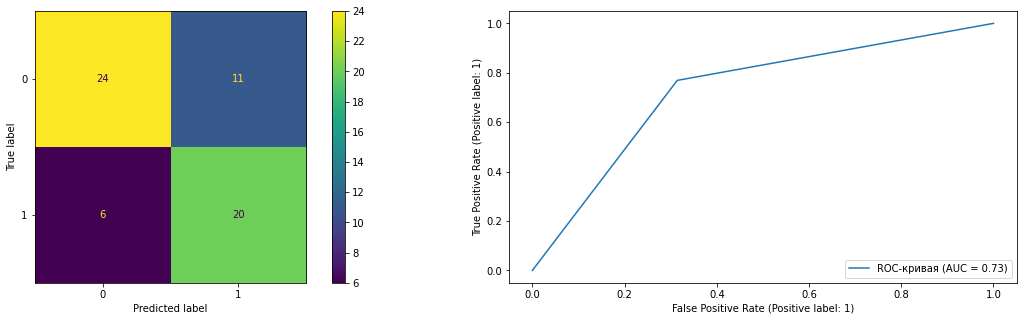

In [33]:
log = Pipeline(steps = [('normalizer', Normalizer()),('log', Logistic(0.1, 10, 5))])
gcv = GridSearchCV(estimator = log, param_grid={'log__nepoch': [1, 5, 10, 20], 'log__batch_size': [1, 5, 10], 'log__lr': [0.1, 0.01, 0.001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
 
log_best = gcv.best_estimator_
scores(log_best, x_test, test_labels)

In [34]:
with open('best_Logistic.pickle', 'wb') as f:
    pickle.dump(gcv.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

{'knn__k': 22}
Accuracy train: 0.7023809523809523
Accuracy: 0.7213114754098361
Recall: 0.8461538461538461
Precision: 0.6285714285714286


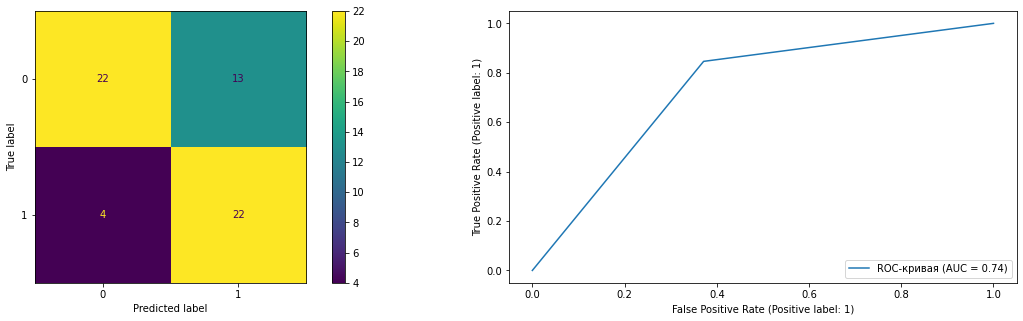

In [35]:
knn = Pipeline(steps = [('knn', KNN(4))])
test = []

for i in range(1, 25):
    test.append(i)

gcv = GridSearchCV(estimator = knn, param_grid={'knn__k': test})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
 
knn_best = gcv.best_estimator_
scores(knn_best, x_test, test_labels)

In [36]:
with open('best_knn.pickle', 'wb') as f:
    pickle.dump(gcv.best_estimator_, f, pickle.HIGHEST_PROTOCOL)

{'bn__bins': 2}
Accuracy train: 0.7894557823129251
Accuracy: 0.8032786885245902
Recall: 0.7307692307692307
Precision: 0.7916666666666666


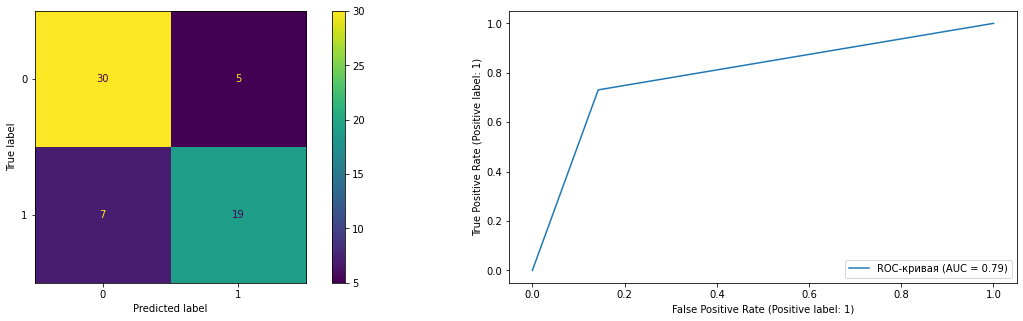

In [37]:
bn = Pipeline(steps = [('normalizer', Normalizer()), ('bn', NaiveBayes(10))])
test = []
for i in range(2, 100):
    test.append(i)

gcv = GridSearchCV(estimator = bn, param_grid={'bn__bins': test})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
 
bn_best = gcv.best_estimator_
scores(bn_best, x_test, test_labels)

In [38]:
with open('best_bayes.pickle', 'wb') as f:
    pickle.dump(gcv, f, pickle.HIGHEST_PROTOCOL)

In [39]:
test_labels[test_labels == 0] = -1
train_labels[train_labels == 0] = -1

{'lin__batch_size': 1, 'lin__lambd': 0, 'lin__lr': 0.1, 'lin__nepoch': 20}
Accuracy train: 0.7231292517006802
Accuracy: 0.7049180327868853
Recall: 0.7692307692307693
Precision: 0.625


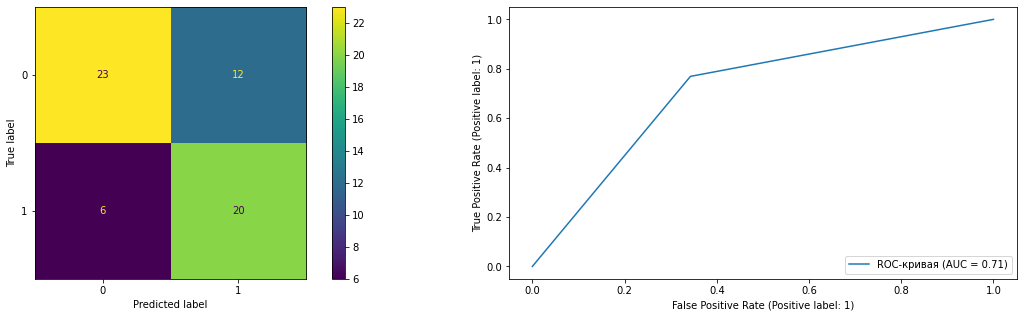

In [40]:
lin = Pipeline(steps = [('normalizer', Normalizer()),('lin', SVM(0.01, 0.01, 10, 3))])
lin.fit(x_train, train_labels)

gcv = GridSearchCV(estimator = lin, param_grid={'lin__lambd': [0, 0.00001, 0.001, 0.1], 'lin__nepoch': [1, 5, 10, 20], 'lin__batch_size': [1, 5, 10], 'lin__lr': [0.1, 0.01, 0.001]})
gcv.fit(x_train, train_labels)
print(gcv.best_params_)
print(f"Accuracy train: {gcv.best_score_}")
 
lin_best = gcv.best_estimator_
scores(lin_best, x_test, test_labels)